# Imports and Settings

In [1]:
## library imports

# data processing imports
import pandas as pd
import numpy as np

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

# modelling imports
from sklearn.model_selection import train_test_split
import imblearn

from sklearn import linear_model
from sklearn import ensemble

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# metric imports
from sklearn import metrics 

# misc imports
import datetime
from dateutil.relativedelta import *
import mlflow

# nlp imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from emoji import demojize

In [2]:
# enable inline plotting
%matplotlib inline 

pd.set_option('display.max_columns', None) # disable column overflow in pandas display, this is toenable us to display all the columns

In [3]:
# general plotting settings

sns.set(style="darkgrid", context="talk") # setting the plot style

# setting the figure size
plt.rcParams["figure.figsize"] = (7, 5)

## PRESENTATION SETTING
# # set the color of the axes and figure (for presentation, with alpha = 0)
# plt.rcParams.update({"axes.facecolor":'#005F32', # ax (in-graph) colour
#                      "figure.facecolor":(0, 0.784313, 0.019607, 0)}) # figure (out-of-graph) colour




# textcolor = '#EBF2FA'
# # setting the colours of the text
# plt.rcParams.update({"text.color":textcolor, 
#                      "axes.labelcolor":textcolor,
#                      "xtick.color":textcolor,
#                      "ytick.color":textcolor})

# # setting teh colours of the grid
# plt.rcParams.update({"grid.color":'white',
#                      "grid.linewidth":0.5, 
#                      "grid.alpha":0.5})

In [4]:
yellow = "#FFBC42" # cc9634 for darker, FFBC42 for brighter
yellows = sns.light_palette(yellow, n_colors=15, reverse=True)
red = "#D81159"
reds = sns.light_palette(red, n_colors=15, reverse=True)

# Create an array with the colors
colors = [yellow, red]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))



# Experiment Tracking on MLFlow

In [5]:
# # This code block is commented out after the model has been finalized

# # Connect this Jupyter notebook to the running MLFlow server 
# import mlflow

# mlflow.set_tracking_uri("sqlite:///mlflow.db")

# # Set the name of the experiment we're running in this notebook
# # MLFlow will connect to an existing experiment or create a new one if the experiment is not already present
# mlflow.set_experiment("stocks_vs_wsb")

# # Start automatically logging experiment details to MLFlow
# mlflow.autolog()

In [6]:
# Start the MLFlow UI
# ! mlflow ui --backend-store-uri sqlite:///mlflow.db

# Data Imports

<span style="color:red">Note: To access the pre-scraped datasets, you will need to export the the .rar files from the 'data_compressed' folder, and put them in the 'data' folder</span>.

In [7]:
df = pd.read_csv('data/df_cleaned.csv') # importing data from saved csv file
df['created'] = pd.to_datetime(df['created']) # convert the created column to a datetime column
df.head() # displaying the top 5 row of the loaded dataframe

,author,created_utc,id,is_self,num_comments,score,selftext,title,upvote_ratio,created,subreddit,subreddit_stocks,title_char_len,title_word_len,score_pmaw
0,cloudboyy,1627751015,ovatu6,False,1,1,NaN,Any thoughts on OSTK? It sold out of the wedge...,1.0,2021-08-01 01:03:35,wsb,0,208,40,1
1,itbc1info,1627751020,ovatwa,False,2,2,NaN,"U.S. prosecutors charge Trevor Milton, founder...",1.0,2021-08-01 01:03:40,wsb,0,61,8,1
2,dadryp,1627751064,ovaudw,True,0,1,NaN,Stocks have been horrible for me 2021,1.0,2021-08-01 01:04:24,stocks,1,37,7,1
3,insta_man,1627751065,ovauee,True,40,7,Long story I started investing in the market w...,Want to get back into investing. Any tips?,1.0,2021-08-01 01:04:25,stocks,1,42,8,1
4,PenIslandGaylien,1627751202,ovavxl,True,1,2,So I already contributed 6k to my Roth in 2021...,Roth Income Limits,1.0,2021-08-01 01:06:42,wsb,0,18,3,1


# Model Setup

Displaying the size of the dataset:

In [8]:
# displaying the size of the dataset from r/stocks and r/wallstreetbets
print(f"No of posts in r/stocks: {df[df['subreddit']=='stocks'].shape[0]}")
print(f"No of posts in r/wsb: {df[df['subreddit']=='wsb'].shape[0]}")

No of posts in r/stocks: 45986
No of posts in r/wsb: 226430


## Setting Features (X) and Target Variables (y)

In [9]:
X = df['title']
y = df['subreddit_stocks']

## Train-Test Split

In [10]:
# conduct train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y) # enabled as the data set this highly imbalanced

## Text Vectorization

### Using Count Vectorizer

In [11]:
# Instantiating the CountVectorizer, use english stopwords, and include n-grams ranging from 1 to 3
cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,3)) 

In [12]:
# Fit-transform our CountVectorizer on the training data and transform testing data.
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

### Using TF-IDF

In [13]:
# Instantiating the TF-IDF, use english stopwords, and include n-grams ranging from 1 to 3
tfidf = TfidfVectorizer(stop_words = 'english',ngram_range=(1,3)) 

In [14]:
# Fit-transform the TF-IDF on the training data and transform testing data.
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Modelling

## Defining Functions

In [15]:
# create function to print the confusion matrix and classification report
def print_results(y_test,y_pred): # inputs are the actual and predicted class
    print(metrics.confusion_matrix(y_test,y_pred))
    print('\n')
    print(metrics.classification_report(y_test,y_pred))
    
# create a function to export the summary of various accuracy metrics
def export_results(y_test,y_pred, # inputs are the actual and predicted class
                   vectorizer='',model='',comments='', # we'll need to input the type of vectorizer, model, as well as the comments manually
                   idno='' # need to input an idno for the index for the summary dataframe
                  ):
    accuracy_df = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).T # generate a dataframe summarizing the accuracy
    accuracy_summary = { # generating a dictionary containing all the various accuracy measures
        'vectorizer':vectorizer,
        'model':model,
        'comments':comments,
        'accuracy':accuracy_df.loc['accuracy','precision'],
        'c1_precision':accuracy_df.loc['1','precision'],
        'c1_recall':accuracy_df.loc['1','recall'],
        'c1_f1':accuracy_df.loc['1','f1-score'],
        'c0_f1':accuracy_df.loc['0','f1-score'],
        'macro_avg_f1':accuracy_df.loc['macro avg','f1-score'],
        'wt_avg_f1':accuracy_df.loc['weighted avg','f1-score'],
    }
    
    return pd.DataFrame(accuracy_summary,index=[idno]) # returns the row containing the detail and accuracy of the specific model

df_accuracy_summary = pd.DataFrame() # instantiating an empty dataframe for containing the accuracty summary

Note that accuracy metrics are always displayed based on  the TEST dataset

## Baseline Predictions

### (0a) Baseline - Naive Prediction: Majority Class

The most basic baseline prediction is to always predict the majority class (in this case r/wsb)

In [16]:
pred_majority = [0]*y_test.shape[0] # generate naive prediction by always predicting majority class (i.e.: class 0)

In [17]:
print_results(y_test,pred_majority)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_majority,
                                                vectorizer='N/A',model='Predict Majority Class',comments='Baseline Model',
                                                idno='0a')])

[[67929     0]
 [13796     0]]


              precision    recall  f1-score   support

           0       0.83      1.00      0.91     67929
           1       0.00      0.00      0.00     13796

    accuracy                           0.83     81725
   macro avg       0.42      0.50      0.45     81725
weighted avg       0.69      0.83      0.75     81725



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

This results in a prediction model where none of the posts from stocks it's labeled correctly.

This means that we would not be able to obtain any posts for the targeted advertising.

### (0b) Baseline - Naive Prediction: Target Class

The other alternative baseline is to always predict the target class (in this case r/stocks)

In [18]:
pred_target = [1]*y_test.shape[0] # generate naive prediction by always predicting target class (i.e.: class 1)

In [19]:
print_results(y_test,pred_target)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_target,
                                                vectorizer='N/A',model='Predict Target Class',comments='Baseline Model',
                                                idno='0b')])

[[    0 67929]
 [    0 13796]]




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     67929
           1       0.17      1.00      0.29     13796

    accuracy                           0.17     81725
   macro avg       0.08      0.50      0.14     81725
weighted avg       0.03      0.17      0.05     81725



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

Using this model, we cover all 100% of r/stocks' posts (100% recall), but also will have a lot of false positive (17% precision)

In an advertising context, this means that we will be wasting quite a lot of our advertising budget by serving the ads to the wrong community / subreddit.

As such we would need to build A proper model that can give a better classification between the two subreddits.

## Multinomial NB with CountVectorizer

The most basic model we can use for classification is the Multinomial Naive Bayes (Multinomial NB).

It calculates the probability of each word/n-gram occuring in each of the class, and then uses both the prior probability (based on the ratio of the classes) as well as the conditional probabilities of each of the words to come up with the probability of the message being in either of the class. The Classifier will then assign that observation to the class with the highest probability.

### (1a) CVEC + Multinomial NB

In [20]:
cvec_nb = MultinomialNB() # instantiating the model
cvec_nb.fit(X_train_cvec, y_train) # fitting the model
pred_cvec_NB = cvec_nb.predict(X_test_cvec) # generating predictions

In [21]:
print_results(y_test,pred_cvec_NB)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_cvec_NB,
                                                vectorizer='CVEC',model='Multinomial NB',comments='Imbalanced dataset',
                                                idno='1a')])

[[67013   916]
 [11088  2708]]


              precision    recall  f1-score   support

           0       0.86      0.99      0.92     67929
           1       0.75      0.20      0.31     13796

    accuracy                           0.85     81725
   macro avg       0.80      0.59      0.61     81725
weighted avg       0.84      0.85      0.82     81725



Using Multinomial NB with CVEC resulted in a model that is better than the baseline. However, this model still performs poorly on predicting posts from the target class (r/stocks). This is because the training dataset is highly imbalanced, which results in a model that favours the majority class.

We can solve this issue by fixing the imbalanced training dataset using various undersampling and oversampling methods.

Do note that we will **not be manipulating the test data set** at all. Doing so will result in an erroneously high accuracy metric for the minority class, but this metric will not be Representative of what we can expect on new datasets (which will still be unbalanced).

### (1b) CVEC + Multinomial NB | Random Undersampling

The simplest method for producing a balanced data set from an imbalanced data set is to reduce the observations in the majority class to match that from the minority class. This method is called random undersampling.

In [22]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state=42) # instantiating the random under-sampler
X_train_cvec_rus, y_train_cvec_rus = rus.fit_resample(X_train_cvec, y_train) # conducting under-sampling of the MAJORITY class in the TRAINING dataset only

In [23]:
cvec_nb_rus = MultinomialNB() # instantiating the model
cvec_nb_rus.fit(X_train_cvec_rus, y_train_cvec_rus) # fitting the model
pred_cvec_nb_rus = cvec_nb_rus.predict(X_test_cvec) # generating the prediction

In [24]:
print_results(y_test,pred_cvec_nb_rus)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_cvec_nb_rus,
                                                vectorizer='CVEC',model='Multinomial NB',comments='Balanced dataset (Random Undersampling)',
                                                idno='1b')])

[[51000 16929]
 [ 3133 10663]]


              precision    recall  f1-score   support

           0       0.94      0.75      0.84     67929
           1       0.39      0.77      0.52     13796

    accuracy                           0.75     81725
   macro avg       0.66      0.76      0.68     81725
weighted avg       0.85      0.75      0.78     81725



Compared to the results from the untreated data setwe can see that the model performs slightly worse on the majority class, and performs much better on the minority class.

However, when doing random undersampling we are in fact throwing away useful information by dropping the extra observations in the majority class. You can observe that there is a slight drop in the weighted average f1-score (from 0.81 to 0.78).

### (1c) CVEC + Multinomial NB | Random Oversampling

The simplest method to conduct oversampling is to do a random oversampling. This is done by sampling observations from the minority class (with replacement) Until the number of observation matches that of the majority class.

In [25]:
ros = imblearn.over_sampling.RandomOverSampler(random_state=42) # instantiating the random over-sampler
X_train_cvec_ros, y_train_cvec_ros = ros.fit_resample(X_train_cvec, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only

In [26]:
cvec_nb_ros = MultinomialNB() # instantiating the model
cvec_nb_ros.fit(X_train_cvec_ros, y_train_cvec_ros) # fitting the model
pred_cvec_NB_ros = cvec_nb_ros.predict(X_test_cvec) # generating the prediction

In [27]:
print_results(y_test,pred_cvec_NB_ros)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_cvec_NB_ros,
                                                vectorizer='CVEC',model='Multinomial NB',comments='Balanced dataset (Random Oversampling)',
                                                idno='1c')])

[[54789 13140]
 [ 3788 10008]]


              precision    recall  f1-score   support

           0       0.94      0.81      0.87     67929
           1       0.43      0.73      0.54     13796

    accuracy                           0.79     81725
   macro avg       0.68      0.77      0.70     81725
weighted avg       0.85      0.79      0.81     81725



The performance of the model with the randomly oversampled dataset is similar to that from the randomly undersampled dataset. However, we can observe a minor improvement in the f1-score for both the minority and majority class. This is because we did not discard any useful information (i.e.: observations) like we did in the random undersampling.

### (1d) CVEC + Multinomial NB | SMOTE Oversampling

We will also attempt another method for oversampling, which is called the Synthetic Minority Oversampling Technique (or SMOTE in short). This type of oversampling it's done by creating synthetic data in between various existing data points [[source]](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

Typically this type of oversampling would yield better metrics compared to the random oversampling [[source]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/). Certain types of models / applications (such as those in medical fields) strongly prefers not to have have synthetic or made-up observations. In this particular project, where we are generating models for applications in the advertising industry, there would be no such problem in generating these synthetic observations.  

Furthermore, SMOTE oversampling requires us to make an assumption that the sample mean and variance is equal to that of the population (which could not always be said is true, especially for medical trials data). However, since we are sampling the entire population of the posts from the two subreddits, we know that the sample *is* equal to the population. As such, this synthetic oversampling technique would be suitable for our problem.

In [28]:
SMOTE = imblearn.over_sampling.SMOTE(n_jobs=-1) # instantiating the SMOTE over-sampler
X_train_cvec_SMOTE, y_train_cvec_SMOTE = SMOTE.fit_resample(X_train_cvec, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only

In [29]:
cvec_nb_SMOTE = MultinomialNB() # instantiating the model
cvec_nb_SMOTE.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model
pred_cvec_NB_SMOTE = cvec_nb_SMOTE.predict(X_test_cvec) # generating the prediction

In [30]:
print_results(y_test,pred_cvec_NB_SMOTE)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_cvec_NB_SMOTE,
                                                vectorizer='CVEC',model='Multinomial NB',comments='Balanced dataset (SMOTE Oversampling)',
                                                idno='1d')])

[[61963  5966]
 [ 6838  6958]]


              precision    recall  f1-score   support

           0       0.90      0.91      0.91     67929
           1       0.54      0.50      0.52     13796

    accuracy                           0.84     81725
   macro avg       0.72      0.71      0.71     81725
weighted avg       0.84      0.84      0.84     81725



The model which incorporates SMOTE Oversampling performs Similarly to those with random oversampling. There is a slight reduction in the f1-score for the minority/target class. However, this is more than made up by the increase in the f1-score for the majority class.

Based on the weighted average f1-score, the Multinomial NB model with CVEC and SMOTE oversampling yielded the best performance metric.

The interpretation of coefficients from the Multinomial NB model will be done in the final section.

## Multinomial NB with TF-IDF Vectorizer

The following section and code box repeats the above experiment but with a TF-IDF vectorizer.

The result of the various sampling method and vectorizer will be discussed in the next section.

### (2a) TF-IDF + Multinomial NB

In [31]:
tfidf_nb = MultinomialNB() # instantiating the model
tfidf_nb.fit(X_train_tfidf, y_train) # fitting the model
pred_tfidf_NB = tfidf_nb.predict(X_test_cvec) # generating the prediction

In [32]:
print_results(y_test,pred_tfidf_NB)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_tfidf_NB,
                                                vectorizer='TF-IDF',model='Multinomial NB',comments='Imbalanced dataset',
                                                idno='2a')])

[[67788   141]
 [12950   846]]


              precision    recall  f1-score   support

           0       0.84      1.00      0.91     67929
           1       0.86      0.06      0.11     13796

    accuracy                           0.84     81725
   macro avg       0.85      0.53      0.51     81725
weighted avg       0.84      0.84      0.78     81725



### (2b) TF-IDF + Multinomial NB | Random Undersampling

In [33]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state=42) # instantiating the random under-sampler
X_train_tfidf_rus, y_train_tfidf_rus = rus.fit_resample(X_train_tfidf, y_train) # conducting under-sampling of the MAJORITY class in the TRAINING dataset only

In [34]:
tfidf_nb_rus = MultinomialNB() # instantiating the model
tfidf_nb_rus.fit(X_train_tfidf_rus, y_train_tfidf_rus) # fitting the model
pred_tfidf_nb_rus = tfidf_nb_rus.predict(X_test_tfidf) # generating the prediction

In [35]:
print_results(y_test,pred_tfidf_nb_rus)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_tfidf_nb_rus,
                                                vectorizer='TF-IDF',model='Multinomial NB',comments='Balanced dataset (Random Undersampling)',
                                                idno='2b')])

[[49111 18818]
 [ 2811 10985]]


              precision    recall  f1-score   support

           0       0.95      0.72      0.82     67929
           1       0.37      0.80      0.50     13796

    accuracy                           0.74     81725
   macro avg       0.66      0.76      0.66     81725
weighted avg       0.85      0.74      0.77     81725



### (2c) TF-IDF + Multinomial NB | Random Oversampling

In [36]:
ros = imblearn.over_sampling.RandomOverSampler(random_state=42) # instantiating the random over-sampler
X_train_tfidf_ros, y_train_tfidf_ros = ros.fit_resample(X_train_tfidf, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only

In [37]:
tfidf_nb_ros = MultinomialNB() # instantiating the model
tfidf_nb_ros.fit(X_train_tfidf_ros, y_train_tfidf_ros) # fitting the model
pred_tfidf_NB_ros = cvec_nb_ros.predict(X_test_tfidf) # generating the prediction

In [38]:
print_results(y_test,pred_tfidf_NB_ros)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_tfidf_NB_ros,
                                                vectorizer='TF-IDF',model='Multinomial NB',comments='Balanced dataset (Random Oversampling)',
                                                idno='2c')])

[[55382 12547]
 [ 4173  9623]]


              precision    recall  f1-score   support

           0       0.93      0.82      0.87     67929
           1       0.43      0.70      0.54     13796

    accuracy                           0.80     81725
   macro avg       0.68      0.76      0.70     81725
weighted avg       0.85      0.80      0.81     81725



### (2d) TF-IDF + Multinomial NB | SMOTE Oversampling

In [39]:
SMOTE = imblearn.over_sampling.SMOTE(n_jobs=-1) # instantiating the SMOTE over-sampler
X_train_tfidf_SMOTE, y_train_tfidf_SMOTE = SMOTE.fit_resample(X_train_tfidf, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only

In [40]:
tfidf_nb_SMOTE = MultinomialNB() # instantiating the model
tfidf_nb_SMOTE.fit(X_train_tfidf_SMOTE, y_train_tfidf_SMOTE) # fitting the model
pred_tfidf_NB_SMOTE = tfidf_nb_SMOTE.predict(X_test_tfidf) # generating the prediction

In [41]:
print_results(y_test,pred_tfidf_NB_SMOTE)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_tfidf_NB_SMOTE,
                                                vectorizer='TF-IDF',model='Multinomial NB',comments='Balanced dataset (SMOTE Oversampling)',
                                                idno='2d')])

[[59204  8725]
 [ 5229  8567]]


              precision    recall  f1-score   support

           0       0.92      0.87      0.89     67929
           1       0.50      0.62      0.55     13796

    accuracy                           0.83     81725
   macro avg       0.71      0.75      0.72     81725
weighted avg       0.85      0.83      0.84     81725



## Comparison of Vectorizer and Sampling Method

In [42]:
df_accuracy_summary[['vectorizer','comments','c1_f1','c0_f1','wt_avg_f1']].loc['1a':'2d'] # displaying the relevant part of the summary table

,vectorizer,comments,c1_f1,c0_f1,wt_avg_f1
1a,CVEC,Imbalanced dataset,0.310907,0.917798,0.815348
1b,CVEC,Balanced dataset (Random Undersampling),0.515270,0.835641,0.781559
1c,CVEC,Balanced dataset (Random Oversampling),0.541793,0.866188,0.811427
1d,CVEC,Balanced dataset (SMOTE Oversampling),0.520808,0.906356,0.841271
2a,TF-IDF,Imbalanced dataset,0.114456,0.911944,0.777320
2b,TF-IDF,Balanced dataset (Random Undersampling),0.503911,0.819534,0.766254
2c,TF-IDF,Balanced dataset (Random Oversampling),0.535116,0.868846,0.812509
2d,TF-IDF,Balanced dataset (SMOTE Oversampling),0.551145,0.894577,0.836602


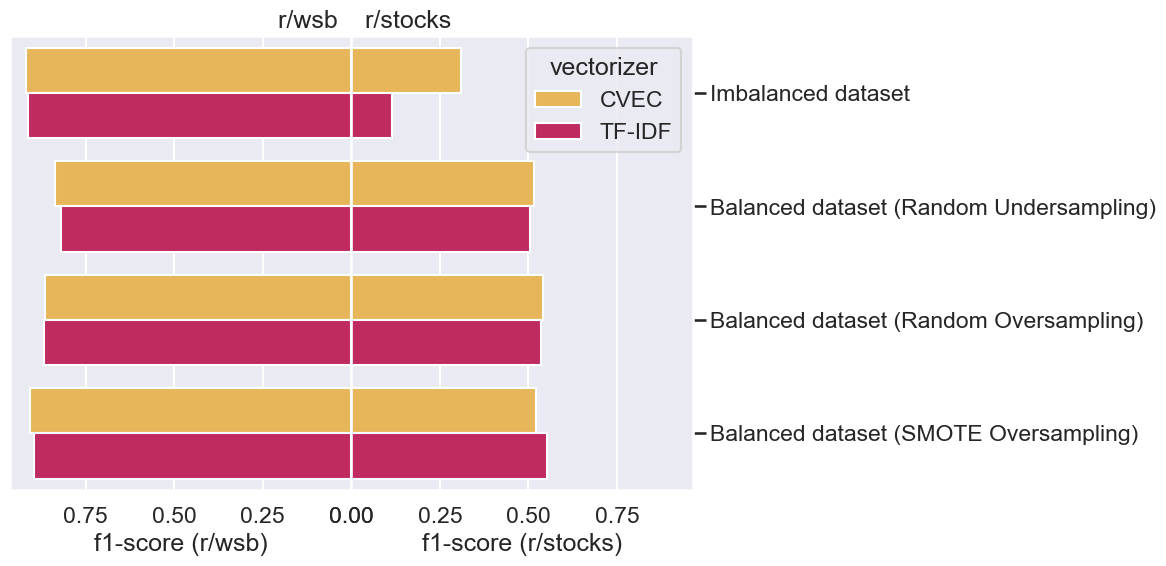

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, gridspec_kw={'wspace': 0})

# draw subplot at the right
sns.barplot(data=df_accuracy_summary.loc['1a':'2d'], 
            x='c1_f1', y='comments',hue='vectorizer',
            orient='horizontal', dodge=True, ax=ax2)
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', labelright=True, right=True)
ax2.set_title('  '+'r/stocks', loc='left')
ax2.set(ylabel='',xlabel='f1-score (r/stocks)')

# draw subplot at the left
sns.barplot(data=df_accuracy_summary.loc['1a':'2d'], 
            x='c0_f1', y='comments',hue='vectorizer',
            orient='horizontal', dodge=True, ax=ax1)

# use the same scale left and right
xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
ax1.set_xlim(xmax=xmax)
ax2.set_xlim(xmax=xmax)

ax1.invert_xaxis()  # reverse the direction
ax1.tick_params(labelleft=False, left=False)
ax1.set_title('r/wsb'+'  ', loc='right')
ax1.set(ylabel='',xlabel='f1-score (r/wsb)')
ax1.legend_.remove() # remove the legend; the legend +will be in ax2

plt.tight_layout()
plt.show()

The figure and table above shows the f1-score for both the target/minority class and the majority class, based on the predictions from models with various vectorizer and sampling methods.
- We can see that the model trained on the imbalanced dataset resulted in best performance best on the majority class and worst on the minority class.
- Using various a sampling technique resulted in a more balanced prediction accuracu between the majority and minority class.
- Using either CVEC and TF-IDF resulted in similar performance across the board.
- The model which performs best for both classes (based on the weighted average f1-score) is the Multinomial NB model with Count Vectorizer and SMOTE Oversampling.
    - As such, both the Count Vectorizer and SMOTE Oversampling will be the default vectorizer and sampling method used for the rest of the modeling.

## (3) Logistic Regression

In [44]:
# cvec_logreg_SMOTE = GridSearchCV(linear_model.LogisticRegression(penalty='l1',solver='liblinear',random_state=42), # instantiating the gridsearch for the logistic regression model
#                                  param_grid={'C':1/np.logspace(-3,1,10)}, # setting the search grid for 'C' (i.e.: the regularization strength 1/alpha)
#                                  scoring='f1', # setting the scoring method
#                                  verbose=3,n_jobs=-1, # setting the verbosity of the report, as well as the number of threads to be used to maximum
#                                 )

# based on the gridsearch above, the best parameter is: {'C': 359.38136638046257} which obtained a CV score of 0.8298082801257396


# print(f"Best Parameter: {cvec_logreg_SMOTE.best_params_}") # displaying the best parameter
# print(f"Best Score: {cvec_logreg_SMOTE.best_score_}") # displaying the best CV score

cvec_logreg_SMOTE = linear_model.LogisticRegression(penalty='l1',solver='liblinear',random_state=42,C=359.38136638046257)

cvec_logreg_SMOTE.fit(X_train_cvec_SMOTE,y_train_cvec_SMOTE) # fitting the model

LogisticRegression(C=359.38136638046257, penalty='l1', random_state=42,
                   solver='liblinear')

In [45]:
# cvec_logreg_SMOTE = GridSearchCV(linear_model.LogisticRegression(penalty='l1',solver='liblinear',random_state=42), # instantiating the gridsearch for the logistic regression model
#                                  param_grid={'C':1/np.logspace(-3,1,10)}, # setting the search grid for 'C' (i.e.: the regularization strength 1/alpha)
#                                  scoring='f1', # setting the scoring method
#                                  verbose=3,n_jobs=-1, # setting the verbosity of the report, as well as the number of threads to be used to maximum
#                                 )

# based on the gridsearch above, the best parameter is: {'C': 359.38136638046257} which obtained a CV score of 0.8298082801257396


# print(f"Best Parameter: {cvec_logreg_SMOTE.best_params_}") # displaying the best parameter
# print(f"Best Score: {cvec_logreg_SMOTE.best_score_}") # displaying the best CV score

cvec_logreg_SMOTE = linear_model.LogisticRegression(penalty='l1',solver='liblinear',random_state=42,C=359.38136638046257)

cvec_logreg_SMOTE.fit(X_train_cvec_SMOTE,y_train_cvec_SMOTE) # fitting the model

LogisticRegression(C=359.38136638046257, penalty='l1', random_state=42,
                   solver='liblinear')

In [46]:
pred_cvec_logreg_SMOTE = cvec_logreg_SMOTE.predict(X_test_cvec) # generating the predictions

In [47]:
print_results(y_test,pred_cvec_logreg_SMOTE)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_cvec_logreg_SMOTE,
                                                vectorizer='CVEC',model='Logistic Regression',comments='Balanced dataset (SMOTE Oversampling)',
                                                idno='3')])

[[57722 10207]
 [ 7141  6655]]


              precision    recall  f1-score   support

           0       0.89      0.85      0.87     67929
           1       0.39      0.48      0.43     13796

    accuracy                           0.79     81725
   macro avg       0.64      0.67      0.65     81725
weighted avg       0.81      0.79      0.80     81725



### Interpretation of Coefficients

We can interpret the coefficients of the logistic regression model to see which of the n-grams are the most related to each of the subreddits.

In [48]:
# casting the coefficient (and it's labels) to a dataframe
cvec_logreg_SMOTE_coeffs_df = pd.DataFrame(cvec_logreg_SMOTE.coef_[0],index=cvec.get_feature_names_out(),columns=['coef'])
print('n-grams related to r/stocks')
display(cvec_logreg_SMOTE_coeffs_df.sort_values('coef',ascending=False).head(10)) # displaying the top ten positive coefficients
print('\n')
print('n-grams related to r/wsb')
display(cvec_logreg_SMOTE_coeffs_df.sort_values('coef',ascending=True).head(10)) # displaying the top ten negative coefficients

n-grams related to r/stocks


,coef
body dick,47.001827
tdoc talk,46.780733
isn funny,43.978312
boy glad,38.320677
today jim,36.301259
bitcoin,35.297137
stocks real,34.602307
gov shutdown,34.145469
hit time high,33.462778
family life,33.324115




n-grams related to r/wsb


,coef
stocks benefit epic,-27.149191
term dividend stocks,-26.125038
good platform buy,-25.389976
ttm charging,-24.349166
app invest stocks,-24.139413
redux,-24.066178
starting advice beginner,-23.968586
increased arcadeland,-23.412561
25 wealthsimple,-22.516532
sectors invested,-22.515973


The result shown above is somewhat unexpected, as it doesn't match the result obtained in the preliminary EDA (see notebook 2).

However, we can see that the ngram is more related to stocks here those more related to cryptocurrency (doge, bitcoin crypto). On the other hand, the n-grams related to WSB are even more random, though we can see several commonly-repated phrases (e.g.: yolo).

When we manually look for the coefficient of the n-grams from notebook 2, we can see that these n-grams still have the correct sign (i.e.: positive for r/stocks and negative for r/wsb) despite having a smaller magnitude.

In [49]:
display(cvec_logreg_SMOTE_coeffs_df.loc[['gme','yolo','apes','wsb','clov','going moon','life savings','short sellers','buy buy buy']])
display(cvec_logreg_SMOTE_coeffs_df.loc[['beginner','index','etf','etfs','long term','index fund','investing stocks','dividend stock','dollar cost averaging']])

,coef
gme,-5.237397
yolo,-7.273103
apes,-12.286384
wsb,-14.262672
clov,-6.760210
going moon,-9.020488
life savings,0.385321
short sellers,-5.443369
buy buy buy,-5.648132


,coef
beginner,0.569143
index,2.774659
etf,2.862410
etfs,2.419544
long term,7.474466
index fund,1.956142
investing stocks,1.999085
dividend stock,6.691500
dollar cost averaging,0.000000


### Number of Non-Zero Coefficients

In [50]:
# Display number of non-null coefficients
cvec_logreg_SMOTE_coeffs_df['coef'].astype(bool).sum(axis=0)

172048

In [51]:
# display ratio of non non coefficients against total number of coefficients
cvec_logreg_SMOTE_coeffs_df['coef'].astype(bool).sum(axis=0) / cvec_logreg_SMOTE_coeffs_df['coef'].shape[0]

0.14591579445522015

The calculations above shows that the regularization method used in the logistic regression has eliminated a large majority of the n-grams.

In fact, only about 16% of the n-grams were deemed significant in the logistic regression model.

## (4) Random Forest Classifier

We have also trained two more complex models, namely: the Random Forest Classifier and the AdaBoost Classifier.

In [52]:
cvec_rfc_SMOTE = ensemble.RandomForestClassifier(n_estimators=1000, max_depth=100, min_samples_leaf=1, min_samples_split=0.5, # The hyperparameters are chosen based on the best result from the randomized search shown below
                                                 random_state=42,n_jobs=-1)
cvec_rfc_SMOTE.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model
pred_cvec_rfc_SMOTE = cvec_rfc_SMOTE.predict(X_test_cvec) # generating the prediction

In [53]:
print_results(y_test,pred_cvec_rfc_SMOTE)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_cvec_rfc_SMOTE,
                                                vectorizer='CVEC',model='Random Forest Classifier',comments='Balanced dataset (SMOTE Oversampling)',
                                                idno='4')])

[[46782 21147]
 [ 5110  8686]]


              precision    recall  f1-score   support

           0       0.90      0.69      0.78     67929
           1       0.29      0.63      0.40     13796

    accuracy                           0.68     81725
   macro avg       0.60      0.66      0.59     81725
weighted avg       0.80      0.68      0.72     81725



Surprisingly the RFC Model performed worse on classifying both the majority and the minority class, compared to the multinomial NB model.

In [54]:
# The lines of code below are used to find the optimal hyperparameters for the random forest classifier

# # defining the search space for the RFC randomized search
# cvec_rfc_SMOTE_search_space =  {'n_estimators':[100,500,750,1000],
#                                'max_depth':[5,10,50,100],
#                                'min_samples_split':[0.1,0.5,1],
#                                'min_samples_leaf':[0.1,0.5,1]}

# # conducting randomized search to find the optimum parameters for RFC
# cvec_rfc_SMOTE_randomsearch = RandomizedSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42,n_jobs=-1),
#                                                  param_distributions=cvec_rfc_SMOTE_search_space,
#                                                  n_iter=70, scoring='f1_weighted',cv=4, # Setting up 4-fold cross validation for a random 70 parameters combination
#                                                  n_jobs=-1,random_state=42)
# cvec_rfc_SMOTE_randomsearch.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model

# pred_cvec_rfc_SMOTE_randomsearch = cvec_rfc_SMOTE_randomsearch.predict(X_test_cvec) # generating the prediction

# print_results(y_test,pred_cvec_rfc_SMOTE_randomsearch)

# print(cvec_rfc_SMOTE_randomsearch.best_params_)

## (5) AdaBoost Classifier

In [55]:
cvec_adaboost_SMOTE = ensemble.AdaBoostClassifier(n_estimators=1000, learning_rate=1, # The hyperparameters are chosen based on the best result from the randomized search shown below
                                                  random_state=42)
cvec_adaboost_SMOTE.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model
pred_cvec_adaboost_SMOTE = cvec_adaboost_SMOTE.predict(X_test_cvec) # generating the prediction

In [56]:
print_results(y_test,pred_cvec_adaboost_SMOTE)

df_accuracy_summary = pd.concat([df_accuracy_summary,
                                 export_results(y_test,pred_cvec_adaboost_SMOTE, 
                                                vectorizer='CVEC',model='AdaBoost Classifier',comments='Balanced dataset (SMOTE Oversampling)',
                                                idno='5')])

[[49659 18270]
 [ 5008  8788]]


              precision    recall  f1-score   support

           0       0.91      0.73      0.81     67929
           1       0.32      0.64      0.43     13796

    accuracy                           0.72     81725
   macro avg       0.62      0.68      0.62     81725
weighted avg       0.81      0.72      0.75     81725



Again, similar to the RFC Model, the AdaBoost model also performed worse on classifying both the majority and the minority class|, compared to the multinomial NB model.

In [57]:
# # The lines of code below are used to find the optimal hyperparameters for the random forest classifier

# # defining the search space for the AdaBoost randomized search
# cvec_adaboost_SMOTE_search_space = {'n_estimators':[50,100,500,1000],
#                                     'learning_rate':[0.1,0.5,1,5,10]}

# # conducting randomized search to find the optimum parameters for RFC
# cvec_adaboost_SMOTE_randomsearch = RandomizedSearchCV(estimator=ensemble.AdaBoostClassifier(random_state=42),
#                                                  param_distributions=cvec_adaboost_SMOTE_search_space, 
#                                                  n_iter=10, scoring='f1_weighted',cv=4, # Setting up 4-fold cross validation for a random 70 parameters combination
#                                                  n_jobs=-1,random_state=42)

# cvec_adaboost_SMOTE_randomsearch.fit(X_train_cvec_short_SMOTE, y_train_cvec_short_SMOTE) # fitting the model

# pred_cvec_adaboost_SMOTE_randomsearch = cvec_adaboost_SMOTE_randomsearch.predict(X_test_cvec_short) # generating the prediction

# print_results(y_test,pred_cvec_adaboost_SMOTE_randomsearch)

# print(cvec_adaboost_SMOTE_randomsearch.best_params_)

# Summary of Models

In [58]:
df_accuracy_summary.index.name='id'

In [59]:
df_accuracy_summary.round(3)

,vectorizer,model,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
id,,,,,,,,,,
0a,N/A,Predict Majority Class,Baseline Model,0.831,0.000,0.000,0.000,0.908,0.454,0.755
0b,N/A,Predict Target Class,Baseline Model,0.169,0.169,1.000,0.289,0.000,0.144,0.049
1a,CVEC,Multinomial NB,Imbalanced dataset,0.853,0.747,0.196,0.311,0.918,0.614,0.815
1b,CVEC,Multinomial NB,Balanced dataset (Random Undersampling),0.755,0.386,0.773,0.515,0.836,0.675,0.782
1c,CVEC,Multinomial NB,Balanced dataset (Random Oversampling),0.793,0.432,0.725,0.542,0.866,0.704,0.811
1d,CVEC,Multinomial NB,Balanced dataset (SMOTE Oversampling),0.843,0.538,0.504,0.521,0.906,0.714,0.841
2a,TF-IDF,Multinomial NB,Imbalanced dataset,0.840,0.857,0.061,0.114,0.912,0.513,0.777
2b,TF-IDF,Multinomial NB,Balanced dataset (Random Undersampling),0.735,0.369,0.796,0.504,0.820,0.662,0.766
2c,TF-IDF,Multinomial NB,Balanced dataset (Random Oversampling),0.795,0.434,0.698,0.535,0.869,0.702,0.813


The table above displays the accuracy metric Of all the different models tested in this study. 
- The baseline models performs poorly on generating a balanced prediction. This resulted in a low f1-score for either/both of the majority and minority class
- The Multinomial NB model with Count Vectorizer performed best out of all the models tested
    - Training the model on an imbalanced dataset resulted in low prediction accuracy for the minority class
    - Using sampling techniques such as random undersampling, random oversampling, and SMOTE oversampling resulted in significantly improved accuray in predicting the minority class
    - The best sampling technique were found to be SMOTE oversampling
- The performance of Multinomial MB model with TF-IDF is similar to the one with Count Vectorizer
- The Count Vectorizer with SMOTE oversampling performed the best based on the accuracy metric. As such, this combination of vectorizer and sampling method will be used to build the other more complex models.
- The Logistic Regression model performed slightly worse compared to the Multinomial NB model
    - Through Regularization, the LogReg model eliminated about 85% of the n-grams in its final model
    - The coefficients of the LogReg model were analyzed and compared to those found during the EDA phase
- Both the Random Forest Classifier and AdaBoost classifier performed significantly worse compared to the Multinomial NB models

As such, we can conclude that the best model for classifying r/wsb and r/stock subreddit (for advertising purposes) would be the Multinomial NB model with Count Vectorizer and SMOTE oversampling.

# Variations on Final Model

In this section, we will investigate the impact of several text preprocessing methods, as well as varying different vectorizer parameters on the prediction accuracy of the proposed model.

The following variations are made to the final model:
- Classifying only posts with more than three or five words
- Converting emoji into text data
- Combining selftext and title
- Changing n-gram range to only consider up to 1-gram and 2-gram
- Reducing features considered in the word vectorizer to 10, 5, and 1% of the default

## Defining Functions

In [60]:
# creating a function to run the full classification model and generating the accuracy metrics

def run_full_analysis(df_test,comment_str,
                      vectorizer=CountVectorizer(stop_words = 'english',ngram_range=(1,3))):
    
    # splitting the dataframe to X and y
    X = df_test['title']
    y = df_test['subreddit_stocks']

    # conduct train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y) # not really required for balanced response values, but no harm to just include by default

    # Instantiating the CountVectorizer, use english stopwords, and include n-grams ranging from 1 to 3
    cvec = vectorizer 

    # Fit-transform our CountVectorizer on the training data and transform testing data.
    X_train_cvec = cvec.fit_transform(X_train)
    X_test_cvec = cvec.transform(X_test)

    SMOTE = imblearn.over_sampling.SMOTE(n_jobs=-1) # instantiating the SMOTE over-sampler
    X_train_cvec_SMOTE, y_train_cvec_SMOTE = SMOTE.fit_resample(X_train_cvec, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only

    cvec_nb_SMOTE = MultinomialNB() # instantiating the model
    cvec_nb_SMOTE.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model
    pred_cvec_NB_SMOTE = cvec_nb_SMOTE.predict(X_test_cvec) # generating the prediction

    return export_results(y_test,pred_cvec_NB_SMOTE,comments=comment_str).drop(['vectorizer','model'],axis=1)

## Baseline (Final) Model

In [61]:
# normal run
run1 = run_full_analysis(df,'Final model (Multi-NB, CVEC, SMOTE)')
run1

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,"Final model (Multi-NB, CVEC, SMOTE)",0.843634,0.539483,0.503624,0.520937,0.906569,0.713753,0.841471


## Consider only posts with n or more words

Very short Reddit posts with low word counts might introduce a lot of noise to the data set. Therefore in this series of experiments we attempt to only consider posts with 3 and 10 words or more.

In [62]:
# select only 3 words or more
df2 = df[df['title_word_len']>=3]

run2 = run_full_analysis(df2,'only consider posts with 3 words or more')
run2

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,only consider posts with 3 words or more,0.845252,0.576208,0.486079,0.52732,0.907482,0.717401,0.839972


In [63]:
# select only 10 words or more
df3 = df[df['title_word_len']>=10]

run3 = run_full_analysis(df3,'only consider posts with 10 words or more')
run3

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,only consider posts with 10 words or more,0.864353,0.679019,0.289126,0.405563,0.923441,0.664502,0.840557


The models with minimum word count performed better on classifying the majority class (r/wsb) but performs worse on classifying the minority class (r/stocks).

Overall there's a very slight reduction in the weighted average f1-score. This is caused by the fact that we are dropping significant amounts of information by only considering post with a minimum number of words.

## Converting Emojis into Text

The count of vectorizer does not convert emoji into text and discards emojis entirely. We can use the demojize function In order to convert the emojis into text.

In [64]:
# using emoji info
df4 = df.copy()
df4['title'] = df4['title'].apply(demojize)

run4 = run_full_analysis(df4,'converting emoji into text')
run4

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,converting emoji into text,0.844258,0.54072,0.51399,0.527016,0.906782,0.716899,0.842674


Converting emojis into text resulted in a very slight improvement in predicting both the minority and majority class.

## Combining Selftext and Title

In [65]:
# combine selftext and title

# clear empty and removed selftexts, and replacing them with an empty string
df5 = df.copy()
df5['selftext'].replace('[removed]','',inplace=True)
df5['selftext'] = df5['selftext'].fillna('')

df5['title'] = df5['title'] + " | " + df5['selftext'] # combine selftext and title

run5 = run_full_analysis(df5,'combining title and selftext')
run5

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,combining title and selftext,0.832903,0.505214,0.491664,0.498347,0.899756,0.699052,0.831994


Adding in selftext to the title for the classification resulted in a slightly worse performance for both minority and majority class. This could be due to the fact that the selftext added extra noise to the classification model.

## Chaning n-gram Range

In [66]:
# change n-gram range to (1,1)

run6 = run_full_analysis(df,'change n-gram range to (1,1)',
                         vectorizer=CountVectorizer(stop_words = 'english',ngram_range=(1,1)))
run6

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,"change n-gram range to (1,1)",0.797149,0.431787,0.638228,0.515093,0.871749,0.693421,0.811542


In [67]:
# change n-gram range to (1,2)

run7 = run_full_analysis(df,'change n-gram range to (1,2)',
                         vectorizer=CountVectorizer(stop_words = 'english',ngram_range=(1,2)))
run7

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,"change n-gram range to (1,2)",0.831398,0.500545,0.565454,0.531023,0.897225,0.714124,0.835406


Reducing the n-gram range to (1,1) resulted in a drop of accuracy for both the majority and minority class.

Reducing the n-gram range to (1,2) resulted in a drop of accuracy for the majority class, and a slight increase in accuracy minority class.

However, the overall weighted average f1-score for the models with reduced n-gram range is lower than that of the default setting.

## Reducing the Maximum Number of Features

By default, the Count Vectorizer considers all the possible combinations of n-grams (or features) present in the corpus. 

However, it is possible to specify to allowable number of features in the count vectorizer setting. This could be done in order to reduce the dimension of the trainingdata set to speed up the training process.

In [68]:
# change max-features to 118167 (10% of default)

run8 = run_full_analysis(df,'change max-features to 118167 (10% of default)',
                         vectorizer=CountVectorizer(stop_words = 'english',ngram_range=(1,3),max_features=118168))
run8

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,change max-features to 118167 (10% of default),0.81521,0.464817,0.625326,0.533255,0.8848,0.709028,0.825456


In [69]:
# change max-features to 59083 (5% of default)

run9 = run_full_analysis(df,'change max-features to 59083 (5% of default)',
                         vectorizer=CountVectorizer(stop_words = 'english',ngram_range=(1,3),max_features=59083))
run9

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,change max-features to 59083 (5% of default),0.81483,0.463765,0.62018,0.530687,0.884661,0.707674,0.824907


In [70]:
# change max-features to 11817 (1% of default)

run10 = run_full_analysis(df,'change max-features to 11817 (1% of default)',
                         vectorizer=CountVectorizer(stop_words = 'english',ngram_range=(1,3),max_features=11817))
run10

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,change max-features to 11817 (1% of default),0.810743,0.454297,0.601986,0.517817,0.882267,0.700042,0.820744


As expected imposing a maximum limit on the number of features resulted in a slight drop in overall accuracy. Again this is because we are Reducing the number of training information available to the model.

However we can see that there is only a slight reduction in prediction accuracy (In fact there is a very slight increase in prediction accuracy for the minority class). Therefore, it might be a good idea to reduce the number of features used When conducting hyperparameter tuning for the various models.

## Summary of Variations

In [71]:
pd.concat([run1,run2,run3,run4,run5,run6,run7,run8,run9,run10]).round(3)

,comments,accuracy,c1_precision,c1_recall,c1_f1,c0_f1,macro_avg_f1,wt_avg_f1
,"Final model (Multi-NB, CVEC, SMOTE)",0.844,0.539,0.504,0.521,0.907,0.714,0.841
,only consider posts with 3 words or more,0.845,0.576,0.486,0.527,0.907,0.717,0.840
,only consider posts with 10 words or more,0.864,0.679,0.289,0.406,0.923,0.665,0.841
,converting emoji into text,0.844,0.541,0.514,0.527,0.907,0.717,0.843
,combining title and selftext,0.833,0.505,0.492,0.498,0.900,0.699,0.832
,"change n-gram range to (1,1)",0.797,0.432,0.638,0.515,0.872,0.693,0.812
,"change n-gram range to (1,2)",0.831,0.501,0.565,0.531,0.897,0.714,0.835
,change max-features to 118167 (10% of default),0.815,0.465,0.625,0.533,0.885,0.709,0.825
,change max-features to 59083 (5% of default),0.815,0.464,0.620,0.531,0.885,0.708,0.825
,change max-features to 11817 (1% of default),0.811,0.454,0.602,0.518,0.882,0.700,0.821


The table above summarizes the prediction accuracy of the final model with various adjustments made to the text preprocessing and the count vectorizer parameters.

The model with default parameters (considering all words in the title, with an n-gram range of (1,3) and using all features) performs the best out of all the different variations tested in this study (with the exception of that with adding in the emoji data).

As such, further studies could be done in order to assess the tradeoff between processing time and slight benefits incurred when converting the emoji data into text. 

However, for this study we will retain the initial vectorizer parameters and text processing as the finalized model.

# Final Model

The final model chosen for the classification problem is the Multinomial NB model with count vectorizer and SMOTE oversampling.

The model is able to achieve 0.54 precision and 0.51 recall, which resulted in an f1-score of 0.52 for the target class. All this while maintaining a respectable f1-score of 0.91 for the other class.

## Interpretation of Coefficient

The benefit of using Multinomial NB is that we are able to interpret the cofficients and see which words have the highest odds of appearing in either of the class. The odds ratio can be obtained by extracting the probability of occurence of each feature in each class.

In [72]:
# getting the feature log-probability from the Multinomail NB model class
feature_log_prob_0_df = pd.DataFrame(cvec_nb_SMOTE.feature_log_prob_[0], index=cvec.get_feature_names_out())
feature_log_prob_1_df = pd.DataFrame(cvec_nb_SMOTE.feature_log_prob_[1], index=cvec.get_feature_names_out())

# combining the two dataframes and setting the correctt axis names
feature_log_prob_df = pd.concat([feature_log_prob_0_df,feature_log_prob_1_df],axis=1)
feature_log_prob_df.columns = ['feature_log_prob_in_c0','feature_log_in_c0']

# converting the feature log probability to the feature probability by taking the exponent
feature_log_prob_df[['feature_prob_in_c0','feature_prob_in_c1']] = feature_log_prob_df.apply(np.exp)

# calculating the odds ratio of each feature being in either class
feature_log_prob_df['odds_ratio_of_c1'] = feature_log_prob_df['feature_prob_in_c1'] / feature_log_prob_df['feature_prob_in_c0']
feature_log_prob_df['odds_ratio_of_c0'] = feature_log_prob_df['feature_prob_in_c0'] / feature_log_prob_df['feature_prob_in_c1']

In [73]:
# sorting the values based on the odds ratio of the feature being in class 1 (minority class, or r/stocks)
feature_log_prob_df = feature_log_prob_df.sort_values('odds_ratio_of_c1',ascending=False)

# displaying the top ten features that are most likely to appear in class 1 (r/stocks)
display(feature_log_prob_df.head(10))

,feature_log_prob_in_c0,feature_log_in_c0,feature_prob_in_c0,feature_prob_in_c1,odds_ratio_of_c1,odds_ratio_of_c0
stocks daily discussion,-15.034001,-7.588368,2.956762e-07,0.000506,1712.368826,0.000584
discussion amp,-15.034001,-8.049675,2.956762e-07,0.000319,1079.578554,0.000926
daily discussion amp,-15.034001,-8.049675,2.956762e-07,0.000319,1079.578554,0.000926
thread meme,-15.034001,-8.063986,2.956762e-07,0.000315,1064.238184,0.000940
thread meme stocks,-15.034001,-8.063986,2.956762e-07,0.000315,1064.238184,0.000940
stocks daily thread,-15.034001,-8.202938,2.956762e-07,0.000274,926.174852,0.001080
daily thread meme,-15.034001,-8.202938,2.956762e-07,0.000274,926.174852,0.001080
market recap today,-15.034001,-8.505219,2.956762e-07,0.000202,684.564021,0.001461
stocks daily,-13.647707,-7.156018,1.182705e-06,0.000780,659.635920,0.001516
amp options trading,-15.034001,-9.099751,2.956762e-07,0.000112,377.756617,0.002647


In [74]:
# sorting the values based on the odds ratio of the feature being in class 1 (minority class, or r/stocks)
feature_log_prob_df = feature_log_prob_df.sort_values('odds_ratio_of_c0',ascending=False)

# displaying the top ten features that are most likely to appear in class 1 (r/stocks)
display(feature_log_prob_df.head(10))

,feature_log_prob_in_c0,feature_log_in_c0,feature_prob_in_c0,feature_prob_in_c1,odds_ratio_of_c1,odds_ratio_of_c0
retards,-8.274746,-14.382954,0.000255,5.669728e-07,0.002225,449.532827
loss porn,-8.300599,-13.689807,0.000248,1.133946e-06,0.004566,219.029916
retard,-8.363235,-13.689807,0.000233,1.133946e-06,0.004861,205.731671
retarded,-8.577231,-13.689807,0.000188,1.133946e-06,0.006021,166.097686
degenerates,-9.278259,-14.382954,0.000093,5.669728e-07,0.006068,164.793937
boyfriend,-9.402789,-14.382954,0.000082,5.669728e-07,0.006873,145.498444
porn,-7.929857,-12.773517,0.000360,2.834864e-06,0.007878,126.933051
memes,-9.587263,-14.382954,0.000069,5.669728e-07,0.008265,120.987954
wife boyfriend,-9.668025,-14.382954,0.000063,5.669728e-07,0.008960,111.600957
gain porn,-9.740696,-14.382954,0.000059,5.669728e-07,0.009636,103.778460


In [75]:
feature_log_prob_df_filtered = pd.concat([feature_log_prob_df.head(10),feature_log_prob_df.tail(10)])
feature_log_prob_df_filtered.reset_index(inplace=True)
feature_log_prob_df_filtered.round(3).drop(['feature_prob_in_c0','feature_prob_in_c1'],axis=1)

,index,feature_log_prob_in_c0,feature_log_in_c0,odds_ratio_of_c1,odds_ratio_of_c0
0,retards,-8.275,-14.383,0.002,449.533
1,loss porn,-8.301,-13.690,0.005,219.030
2,retard,-8.363,-13.690,0.005,205.732
3,retarded,-8.577,-13.690,0.006,166.098
4,degenerates,-9.278,-14.383,0.006,164.794
5,boyfriend,-9.403,-14.383,0.007,145.498
6,porn,-7.930,-12.774,0.008,126.933
7,memes,-9.587,-14.383,0.008,120.988
8,wife boyfriend,-9.668,-14.383,0.009,111.601
9,gain porn,-9.741,-14.383,0.010,103.778


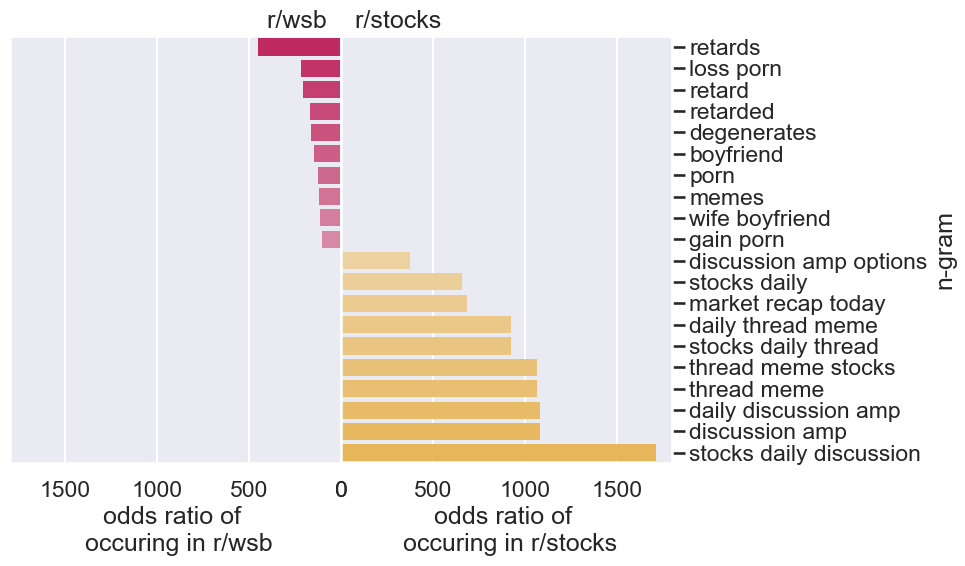

In [76]:
# Setting up the subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6), sharey=True, gridspec_kw={'wspace': 0})

# draw stocks subplot at the right
sns.barplot(data=feature_log_prob_df_filtered, x='odds_ratio_of_c1', y='index',
            orient='horizontal', dodge=True, ax=ax2, palette=sns.light_palette(yellow, n_colors=20, reverse=False), linewidth=0)
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', labelright=True, right=True)
ax2.set_title('  '+'r/stocks', loc='left')
ax2.set_ylabel('n-gram')
ax2.set(xlabel='odds ratio of \n occuring in r/stocks')

# draw wsb subplot at the left
sns.barplot(data=feature_log_prob_df_filtered, x='odds_ratio_of_c0', y='index',
            orient='horizontal', dodge=True, ax=ax1, palette=sns.light_palette(red, n_colors=20, reverse=True), linewidth=0)

# optionally use the same scale left and right
xmax = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
ax1.set_xlim(xmax=xmax)
ax2.set_xlim(xmax=xmax)

ax1.invert_xaxis()  # reverse the direction of the left subpot
ax1.tick_params(labelleft=False, left=False)
ax1.set_ylabel('')
ax1.set_title('r/wsb'+'  ', loc='right')
ax1.set(xlabel='odds ratio of \n occuring in r/wsb')

plt.tight_layout()
plt.show()

The tables above shows the top 10 features that has the highest odds ratio of being in either class.
- The features with the highest odds ratio of appearing in r/stocks is "stocks daily discussion", "thread meme", and "thread meme stocks".
    - These are phrases related to discussion threads that are commonly posted in r/stocks
    - e.g.: there is a daily discussion thread for discussing general stocks (r/stocks Daily Discussion & Technical Tuesdays, r/stocks Daily Discussion & Fundamentals Fridays) or meme stocks (r/stocks Weekly Thread on Meme Stocks)
    - In fact, most of the the top 10 features in the r/stocks are those related to the common discussion thread
    - As such, our model will be predisposed to be (accurately) predicting common discussion threads in r/stocks
        - This is not such a bad thing, since these daily discussion threads are typically visited often by the users, typically with quite high comment counts (albeit with not high scores)
- The features with the highest odds ratio of appearing in r/wsb are those words typically used by members of r/wsb (who typically calls themselves degenerates)
    - Some of the top features includes phrases such as:
        - "retard(s)" - another term for the members of r/wsb call each other, an anagram of traders [[source]](https://news.ycombinator.com/item?id=25939120)
        - "loss (or gain) porn" - where members would post the outcome of a highly risky play which resulted in massive wins or a complete wipeout of their account
        - "diamond hands" - which is a term for someone who has a high-risk tolerance for high volatility stocks or assets that they own

# On the Generalizability of Model

Up to this point, we have used one year worth of data for both the training and testing data set. However, in reality when the model is put into production, we will be using a prebuilt model to predict posts in realtime. We can assume that the model is refreshed monthly.

Therefore it will be interesting to see the performance of a model obtained by train on one month worth of data in classifying posts from an entirely different month.

## Monthly Variations in predictive power

In [77]:
g = df.groupby(pd.Grouper(key='created', freq='M')) # groupby 'created' column by month
df_month = [group for _,group in g] # separate groups to a list of dataframes with list comprehension
# the resulting list will contain 12 dataframes for the twelve months, with df_month[0] being the posts created between 08/2022 and 09/2022

In [78]:
months_dict = {x:df_month[x]['created'].iloc[0].to_period('M') for x in range(13)} # create dictionary that contains the string representation of each month in df_month

In [79]:
# mlflow.autolog(disable=True) # temoporarily disable mlflow autologging feature

# instantiate dataframe to contain all the test results
monthly_test_df = pd.DataFrame()

for train_month in range(12): # looping through each of the month for training data
    
    # define the training data
    X_train = df_month[train_month]['title']
    y_train = df_month[train_month]['subreddit_stocks']
    
    # vectorizing words
    cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,3)) # Instantiating the CountVectorizer, use english stopwords, and include n-grams ranging from 1 to 3
    X_train_cvec = cvec.fit_transform(X_train)
    
    # over-samplling TEST dataset using SMOTE
    SMOTE = imblearn.over_sampling.SMOTE(n_jobs=-1) # instantiating the SMOTE over-sampler
    X_train_cvec_SMOTE, y_train_cvec_SMOTE = SMOTE.fit_resample(X_train_cvec, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only
    
    # training the multinomialNB model on the TEST dataset
    cvec_nb_SMOTE = MultinomialNB() # instantiating the model
    cvec_nb_SMOTE.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model
    
    
    
    for test_month in range (12): # looping from current month to the 12th month for testing data
        
        if train_month == test_month: continue # skips calculating if it's the same month. this will be calculated in a later loop
        
        # print status (optional, can comment out)
        # print(f"Training on {months_dict[train_month]} | Testing on {months_dict[test_month]}")
        
        # define the test data
        X_test = df_month[test_month]['title']
        y_test = df_month[test_month]['subreddit_stocks']
        
        X_test_cvec = cvec.transform(X_test)

        # generating predictions
        pred_cvec_NB_SMOTE = cvec_nb_SMOTE.predict(X_test_cvec) # generating the prediction

        # return summary sheet
        month_result =  export_results(y_test,pred_cvec_NB_SMOTE,idno='')
        
        # adding the training and testing month detail to the dataframe row
        month_result['training_month'] = months_dict[train_month]
        month_result['testing_month'] = months_dict[test_month]
        
        # adding the result row from the month to the monthly_test_df
        monthly_test_df = pd.concat([monthly_test_df,month_result])       

        
        
        
        
for train_month in range(12): # when predicting itself (i.e. it's own month, we cannot use the whole month as the training est, as such, we will do a train-test split here)
    
    # define the training data
    X = df_month[train_month]['title']
    y = df_month[train_month]['subreddit_stocks']
    
    # conduct train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)
    
    # vectorizing words
    cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,3)) # Instantiating the CountVectorizer, use english stopwords, and include n-grams ranging from 1 to 3
    X_train_cvec = cvec.fit_transform(X_train)
    X_test_cvec = cvec.transform(X_test)
    
    # over-samplling TEST dataset using SMOTE
    SMOTE = imblearn.over_sampling.SMOTE(n_jobs=-1) # instantiating the SMOTE over-sampler
    X_train_cvec_SMOTE, y_train_cvec_SMOTE = SMOTE.fit_resample(X_train_cvec, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only
    
    # training the multinomialNB model on the TEST dataset
    cvec_nb_SMOTE = MultinomialNB() # instantiating the model
    cvec_nb_SMOTE.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model
    
    
    # generating predictions
    pred_cvec_NB_SMOTE = cvec_nb_SMOTE.predict(X_test_cvec) # generating the prediction

    # return summary sheet
    month_result =  export_results(y_test,pred_cvec_NB_SMOTE,idno='')

    # adding the training and testing month detail to the dataframe row
    month_result['training_month'] = months_dict[train_month]
    month_result['testing_month'] = months_dict[train_month]

    # adding the result row from the month to the monthly_test_df
    monthly_test_df = pd.concat([monthly_test_df,month_result])       

        
        
# mlflow.autolog(disable=False) # re-enable mlflow autologging feature

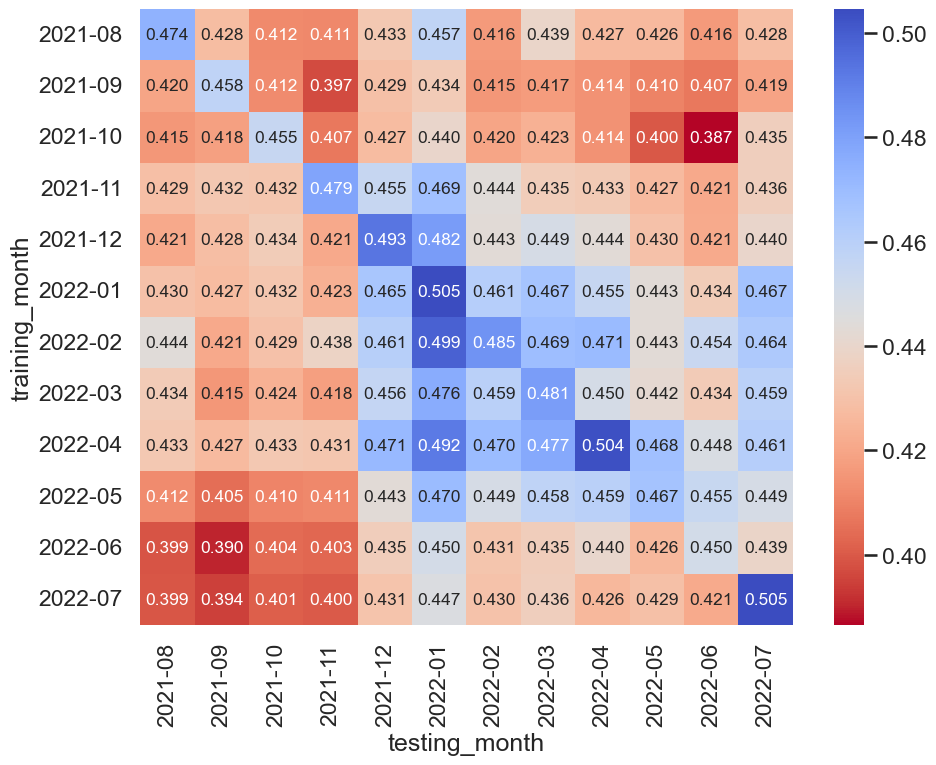

In [80]:
monthly_test_accuracy = monthly_test_df.pivot_table(values='c1_f1',
                                                            columns='testing_month',index='training_month')

plt.figure(figsize=(10,8))
sns.heatmap(monthly_test_accuracy,annot=True,fmt='.3f',cmap='coolwarm_r',annot_kws={'fontsize':'x-small'})
plt.tight_layout()

The heatmap above shows the f1-score of the model when predicting the target class based on various training and testing month.
- The best model performs best when predicting the post from the month in which the model is also being trained on.
    - However this is not a realistic case that will happen in actual production code
    - The more realistic case is where A model train on one month's data is being used to predict post coming in from a different month
- There is a significant and consistent drop (of around 0.05) when the model is predicting the post coming from a different month
    - There is a very slight (but inconsistent) drop of performance as the model predicts posts coming from the months that are further away from which the model is being trained on
    - This indicates a clear presence of "data drift". This is where the underlying distribution shifts over time of the data shifts over time.
        - Such data drift is actually quite expected in data obtained from / relating to social media, because these types of data are typically quite susceptible to periodical changes in trends and topics
        - For our particular example, the data drift could arise from the subreddits discussing different types of stocks at different periods of time (e.g.: discussion of GME which peaks in early 2021 and BBBY in late 2022)

## Using Cumulative Data for Training

One potential method to improve on the prediction model above is to train the model on cumulative data. This means training the model on data obtained from all the previous months and using it to predict the posts in the upcoming months.

In [81]:
def get_cum_df(df_group,start,end):
    output_df = pd.DataFrame()
    
    if start == end: return df_group[start]
    
    for i in range(start,end+1):
        output_df = pd.concat([output_df,df_group[i]])
        
    return output_df

In [ ]:
# mlflow.autolog(disable=True) # temoporarily disable mlflow autologging feature

# instantiate dataframe to contain all the test results
cum_monthly_test_df = pd.DataFrame()

for train_month in range(12): # looping through each of the month for training data
    
    # define the training data
    X_train = get_cum_df(df_month,0,train_month)['title']
    y_train = get_cum_df(df_month,0,train_month)['subreddit_stocks']
    
    
    # vectorizing words
    cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,3)) # Instantiating the CountVectorizer, use english stopwords, and include n-grams ranging from 1 to 3
    X_train_cvec = cvec.fit_transform(X_train)
    
    # over-samplling TEST dataset using SMOTE
    SMOTE = imblearn.over_sampling.SMOTE(n_jobs=-1) # instantiating the SMOTE over-sampler
    X_train_cvec_SMOTE, y_train_cvec_SMOTE = SMOTE.fit_resample(X_train_cvec, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only
    
    # training the multinomialNB model on the TEST dataset
    cvec_nb_SMOTE = MultinomialNB() # instantiating the model
    cvec_nb_SMOTE.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model
    
    
    
    for test_month in range (train_month+1,12): # looping from current month to the 12th month for testing data
        
        if train_month == test_month: continue # skips calculating if it's the same month. this will be calculated in a later loop
        
        # print status (optional, can comment out)
        # print(f"Training on {months_dict[train_month]} | Testing on {months_dict[test_month]}")
        
        # define the test data
        X_test = df_month[test_month]['title']
        y_test = df_month[test_month]['subreddit_stocks']
        
        X_test_cvec = cvec.transform(X_test)

        # generating predictions
        pred_cvec_NB_SMOTE = cvec_nb_SMOTE.predict(X_test_cvec) # generating the prediction

        # return summary sheet
        month_result =  export_results(y_test,pred_cvec_NB_SMOTE,idno='')
        
        # adding the training and testing month detail to the dataframe row
        month_result['training_month'] = months_dict[train_month]
        month_result['testing_month'] = months_dict[test_month]
        
        # adding the result row from the month to the monthly_test_df
        cum_monthly_test_df = pd.concat([cum_monthly_test_df,month_result])
        
        
        
for train_month in range(12): # when predicting itself (i.e. it's own month, we cannot use the whole month as the training est, as such, we will do a train-test split here)
    
    # define the training data
    X = df_month[train_month]['title']
    y = df_month[train_month]['subreddit_stocks']
    
    
    # conduct train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y)
    if train_month > 0:
        # getting the previous months' X and y
        X_train_prev_mo = get_cum_df(df_month,0,train_month-1)['title']
        y_train_prev_mo = get_cum_df(df_month,0,train_month-1)['subreddit_stocks']
        # combining the previous months' X and y with a PART of this months' data
        X_train = pd.concat([X_train,X_train_prev_mo],axis=0)
        y_train = pd.concat([y_train,y_train_prev_mo],axis=0)
    
    # vectorizing words
    cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,3)) # Instantiating the CountVectorizer, use english stopwords, and include n-grams ranging from 1 to 3
    X_train_cvec = cvec.fit_transform(X_train)
    X_test_cvec = cvec.transform(X_test)
    
    # over-samplling TEST dataset using SMOTE
    SMOTE = imblearn.over_sampling.SMOTE(n_jobs=-1) # instantiating the SMOTE over-sampler
    X_train_cvec_SMOTE, y_train_cvec_SMOTE = SMOTE.fit_resample(X_train_cvec, y_train) # conducting over-sampling of the MINORITY class in the TRAINING dataset only
    
    # training the multinomialNB model on the TEST dataset
    cvec_nb_SMOTE = MultinomialNB() # instantiating the model
    cvec_nb_SMOTE.fit(X_train_cvec_SMOTE, y_train_cvec_SMOTE) # fitting the model
    
    
    # generating predictions
    pred_cvec_NB_SMOTE = cvec_nb_SMOTE.predict(X_test_cvec) # generating the prediction

    # return summary sheet
    month_result =  export_results(y_test,pred_cvec_NB_SMOTE,idno='')

    # adding the training and testing month detail to the dataframe row
    month_result['training_month'] = months_dict[train_month]
    month_result['testing_month'] = months_dict[train_month]

    # adding the result row from the month to the monthly_test_df
    cum_monthly_test_df = pd.concat([cum_monthly_test_df,month_result])       
        

        
# mlflow.autolog(disable=False) # re-enable mlflow autologging feature

In [ ]:
cum_monthly_test_accuracy = cum_monthly_test_df.pivot_table(values='c1_f1',
                                                            columns='testing_month',index='training_month')

plt.figure(figsize=(10,8))
sns.heatmap(cum_monthly_test_accuracy,annot=True,fmt='.3f',cmap='coolwarm_r',annot_kws={'fontsize':'x-small'})
plt.tight_layout()

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,9))

sns.heatmap(monthly_test_accuracy,
            annot=True,fmt='.3f',
            cmap='coolwarm_r',cbar=False,
            vmin=0.388, vmax=0.541,
            ax=ax1,
            annot_kws={'fontsize':'x-small'})

sns.heatmap(cum_monthly_test_accuracy,
            annot=True,fmt='.3f',
            cmap='coolwarm_r',cbar=False,
            vmin=0.388, vmax=0.541,
            ax=ax2,
            annot_kws={'fontsize':'x-small'})

fig.tight_layout(rect=[0, 0, .9, 1])


The heatmap above shows the f1-score of the model when predicting the target class based on various training and testing month.

The figure on the left is Based on the previous configuration (i.e.: using once a month for training and one month for testing). The figure on the right is based on models trained on cumulative data used to predict one particular month.
- Models which are trained on more cumulative data (i.e.: the models towards the right side of the right graph) performs even better
- However, data drift is still observed even when using models trained on cumulative data
    - This is evident in the slightly reduced performance in predicting post coming from a months farther from the training dataset
- Overall, using cumulative data results in a significant improvement in prediction accuracy across the board
    - Therefore, in order to improve on the model, we can try to add in more past data for the purposes of training the model